In [1]:
# Pacotes essenciais
import pandas as pd
import matplotlib as mtp
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Pacote de plotagem
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
# Pacotes de pré-processamento
import ppscore as pps
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [24]:
# APIs para aprendizado de máquina
from sklearn.cluster import KMeans,DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA

# Introduction

A presente análise tem como objetivo auxiliar uma loja na elaboração de possíveis campanhas de marketings e na venda de serviços ou produtos novos.

Para tal é necessario à identificação de grupos de clientes-alvo e quais seriam suas características.

Portanto será analisado o dataset contendo algumas informações básicas dos consumidores do shopping onde esta loja está alocada, identificando quais seriam os grupos mais importantes para serem focados/trabalhados pela equipe de marketing.


**<h1>Vizualization data<h1>**

In [4]:
data = pd.read_csv('segmentation data.csv')
describe = pd.read_excel('describe_seg.xlsx')

In [5]:
data.head(10)

ID  Sex  Marital status  Age  Education  Income  Occupation  \
0  100000001    0               0   67          2  124670           1   
1  100000002    1               1   22          1  150773           1   
2  100000003    0               0   49          1   89210           0   
3  100000004    0               0   45          1  171565           1   
4  100000005    0               0   53          1  149031           1   
5  100000006    0               0   35          1  144848           0   
6  100000007    0               0   53          1  156495           1   
7  100000008    0               0   35          1  193621           2   
8  100000009    0               1   61          2  151591           0   
9  100000010    0               1   28          1  174646           2   

   Settlement size  
0                2  
1                2  
2                0  
3                1  
4                1  
5                0  
6                1  
7                1  
8                0  
9                0

In [6]:
print(tabulate(describe, tablefmt="github",showindex=False))

|-----------------|-------------|-----------|---------------------------------------------------------------------------------------------------------------------------------------------|
| ID              | numerical   | Integer   | Shows a unique identificator of a customer.                                                                                                 |
| Sex             | categorical | {0,1}     | Biological sex (gender) of a customer. In this dataset there are only 2 different options.                                                  |
| nan             | nan         | 0         | male                                                                                                                                        |
| nan             | nan         | 1         | female                                                                                                                                      |
| Marital status  | categorical | {0,1}     | Marital status

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   ID               2000 non-null   int64
 1   Sex              2000 non-null   int64
 2   Marital status   2000 non-null   int64
 3   Age              2000 non-null   int64
 4   Education        2000 non-null   int64
 5   Income           2000 non-null   int64
 6   Occupation       2000 non-null   int64
 7   Settlement size  2000 non-null   int64
dtypes: int64(8)
memory usage: 125.1 KB


In [8]:
data['ID'].duplicated().any()

False

Analisando os tipos de dados do dataset não é possível notar a repetição de algum tipo de consumidor em específico ou a presença de dados ausentes. 

Nota-se também que não é possível identificar a qual tipo de ramo a loja analisada pertence por meio das features apresentadas.


**<h1> Exploratory Data Analysis <h1>**

Para uma melhor entendimento e vizualização dos dados as features categóricas serão decodificadas com base no 'describe segmentation' disponibilizado.

In [9]:
data_view = data.copy()
data_view['Sex'] = data_view['Sex'].map({1:'female', 0:'male'}) 
data_view['Marital status'] = data_view['Marital status'].map({1:'non-single', 0:'single'}) 
data_view['Education'] = data_view['Education'].map({3:'graduate school', 2:'university', 1:'high school', 0:'unknown'}) 
data_view['Occupation'] = data_view['Occupation'].map({2:'highly qualified employee', 1:'employee', 0:'unemployed '}) 
data_view['Settlement size'] = data_view['Settlement size'].map({2:'big city', 1:'mid-size city', 0:'small city'}) 

Para um entendimento inicial do dados será feito vizualizações voltadas para segregação/separação por meio do 'settlement size'.

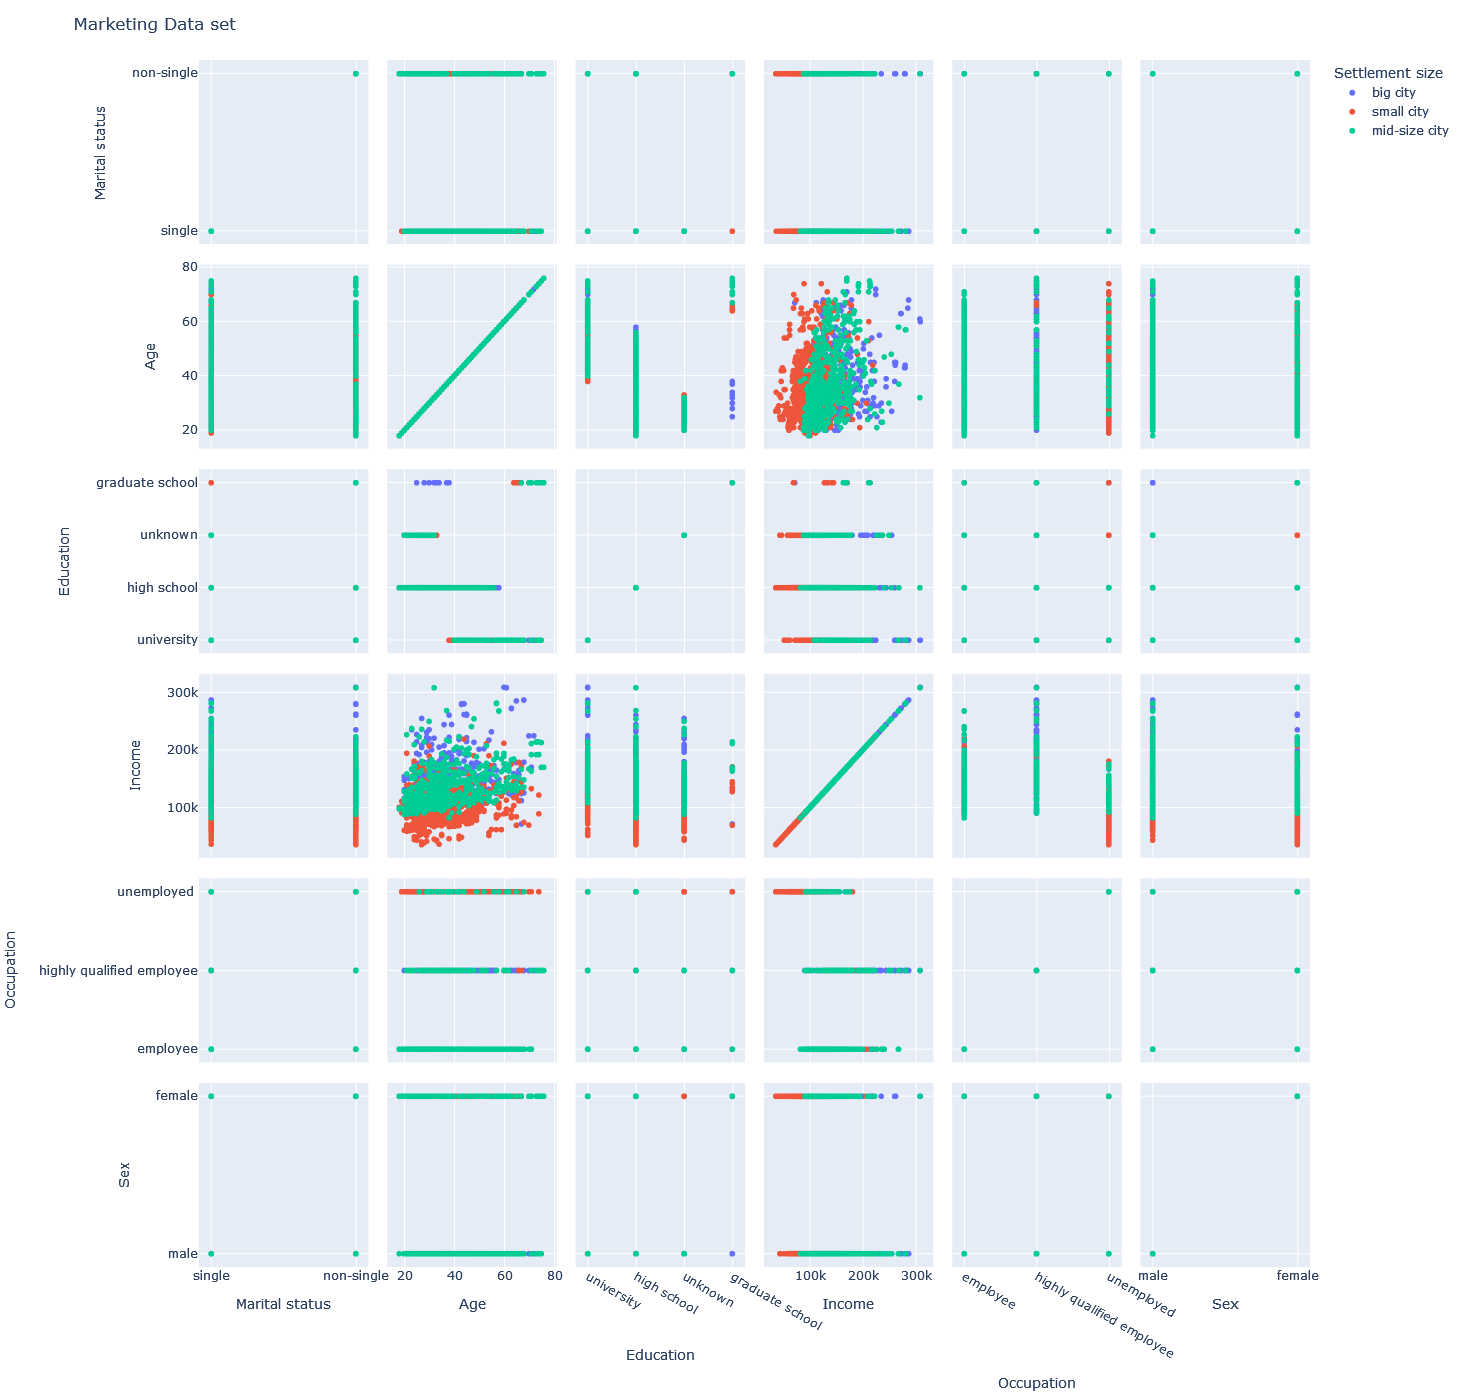

In [10]:
fig = px.scatter_matrix(data_view,dimensions=["Marital status","Age","Education","Income","Occupation","Sex"], color ="Settlement size")
#fig.update_traces(diagonal_visible=False)
fig.update_layout(
    title='Marketing Data set',
    dragmode='select',
    width=1400,
    height=1400,
    hovermode='closest',
)
fig.show()

Observando os gráficos pode-se obter os seguintes insights:
- Nas 'big city' a maioria dos 'graduate school' estão na faixa dos 20 à 40 anos.
- Nas 'small city' a tendência é das pessoas terem menor poder aquisitivo, menores incomes, e conforme o tamanho da cidade aumenta o poder aquisitivo também aumenta.
- Para as pessoas com 'Occupation' classificadas como 'unemployed' possuem 'Incomes' menores no geral, porém pessoas com 'Occupation' de 'employee' e 'highly qualified employee' não possuem diferenças altas de 'Income'.
- É possível observar uma grande igualdade de gênero em relação ao 'Income' e ao 'Age' dos dados coletados.

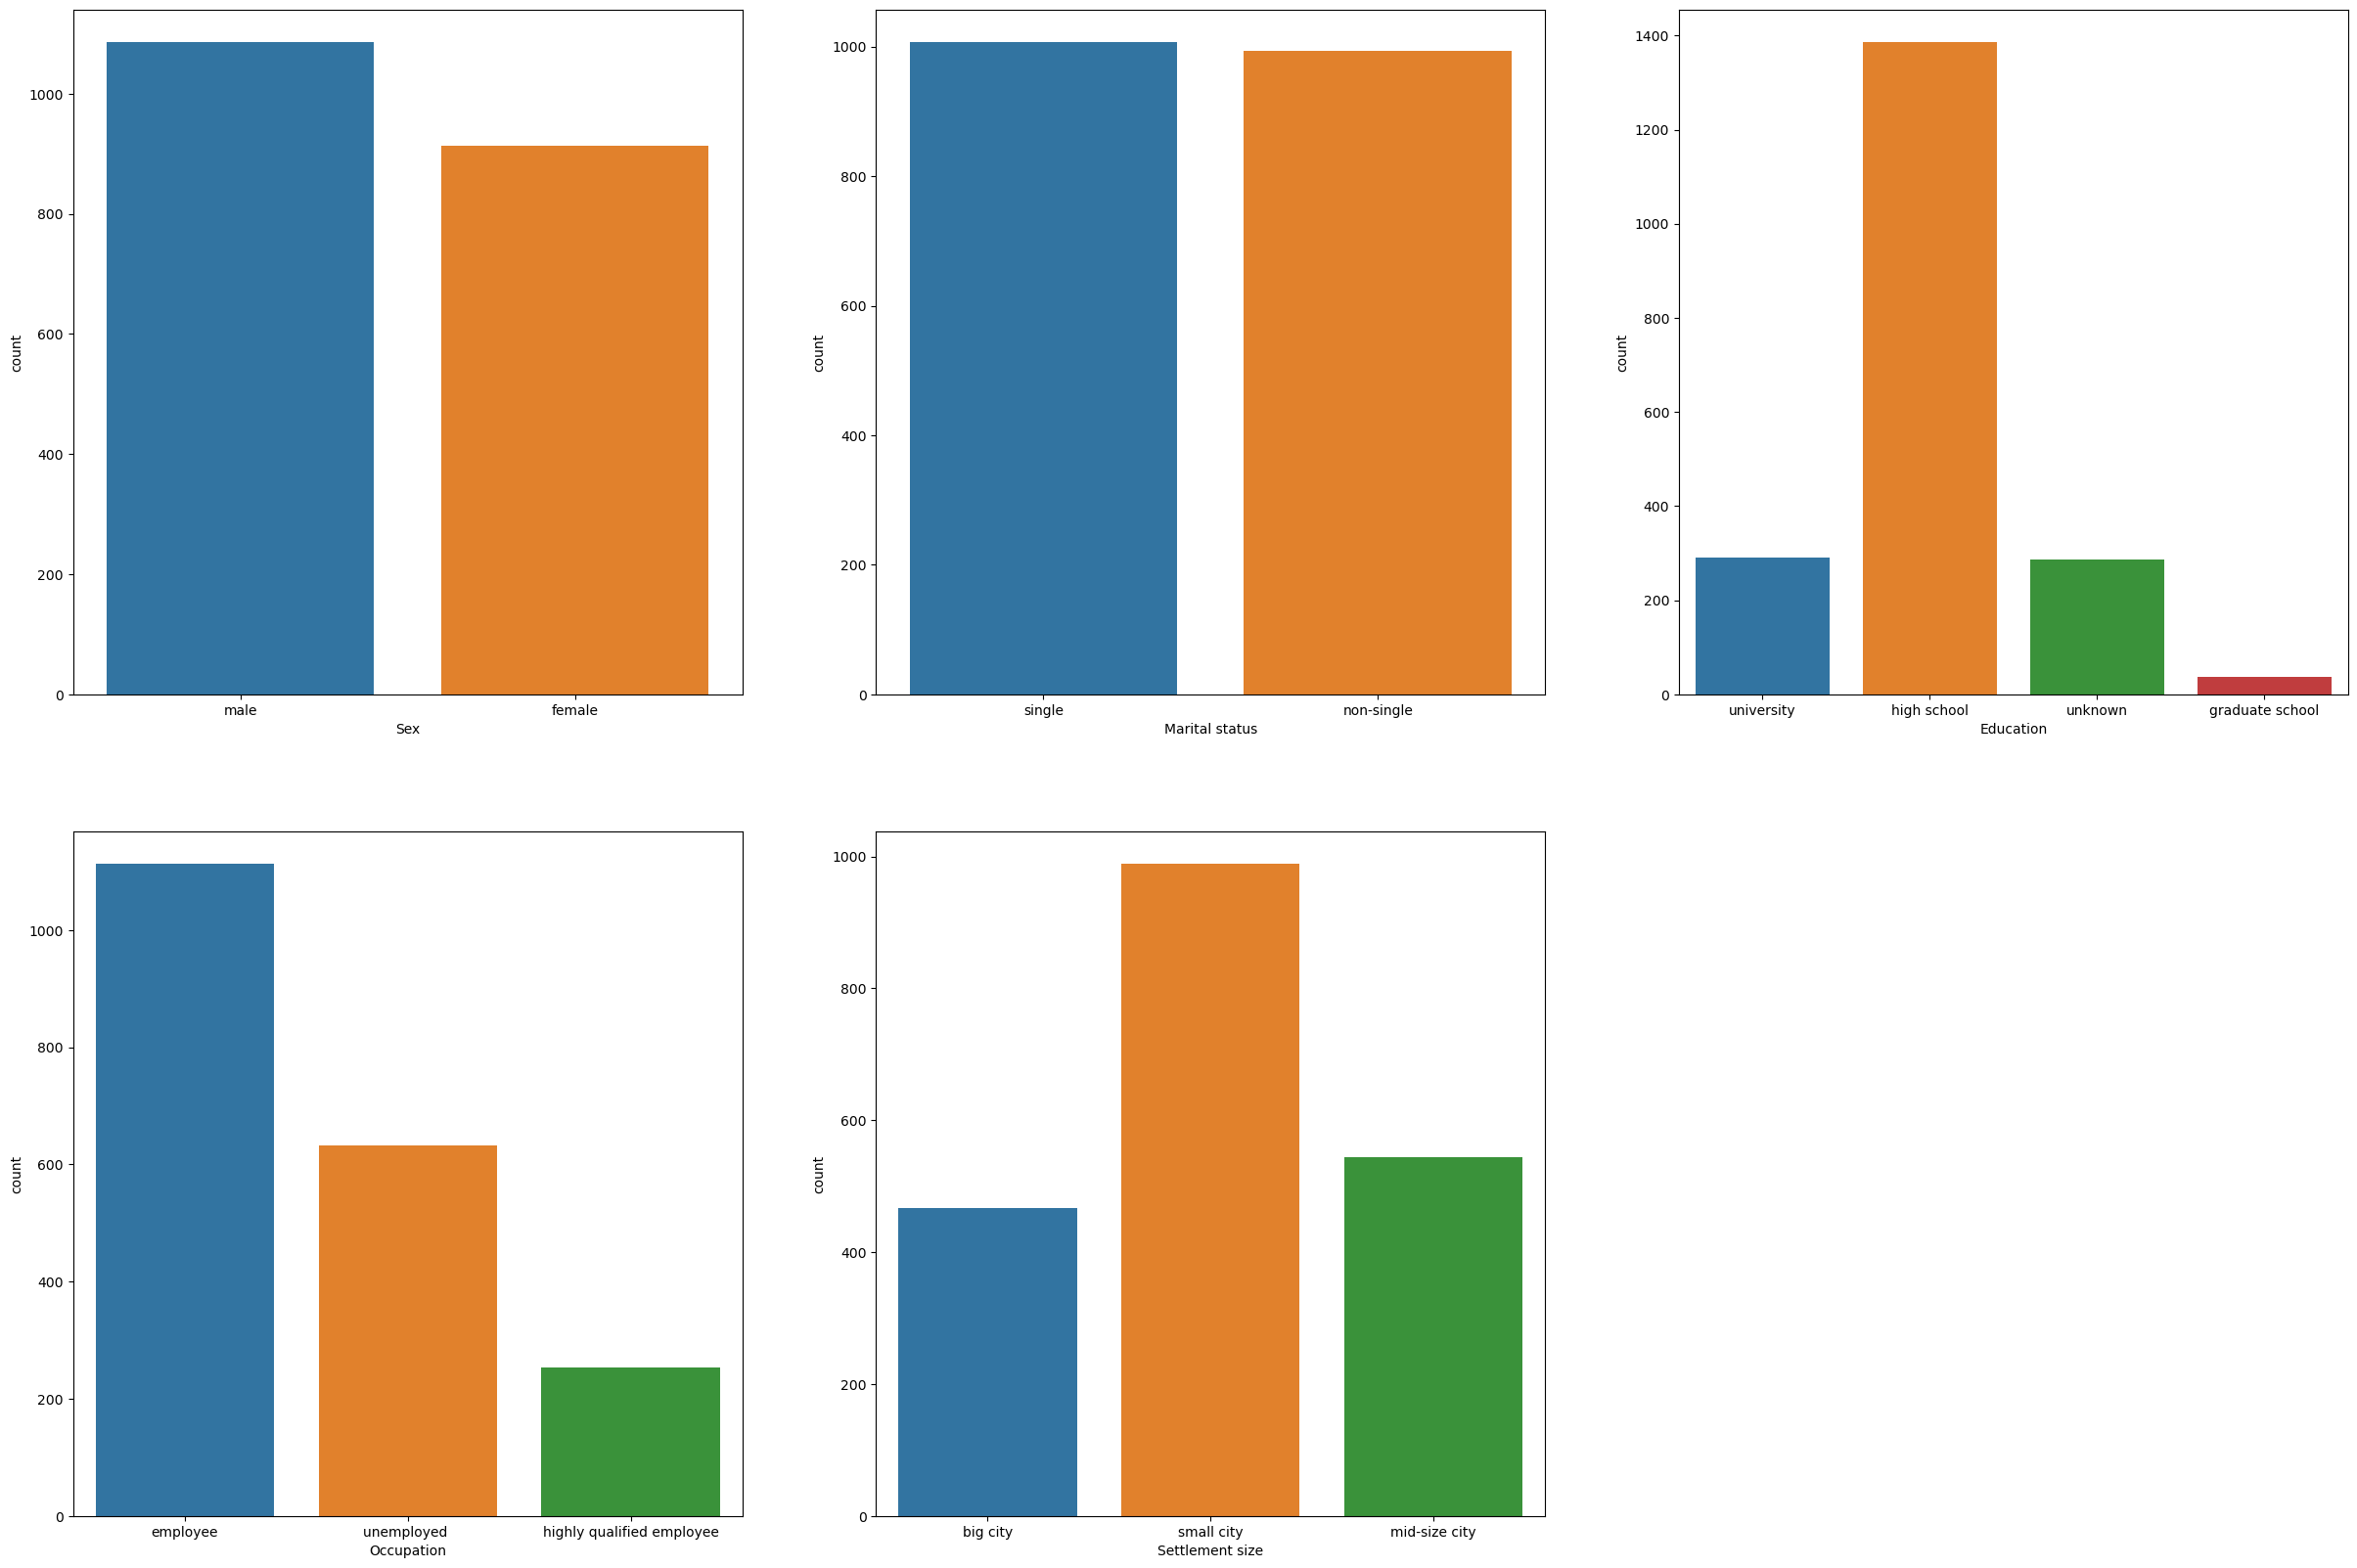

In [11]:
cols = data.columns
col_name = cols.drop('Age')
col_name = col_name.drop('Income')
col_name = col_name.drop('ID')
col_num = col_name.shape[0]
fig, ax = plt.subplots(2, 3,figsize=(30,20), sharey=False)
axes = ax.flatten()

fig.delaxes(axes[5])
for i in range(0,col_num):
    sns.countplot(data= data_view, x = col_name[i], ax=axes[i])

Com base nestes gráficos pode-se observar as seguintes características:
- Não existe uma grande diferença de dados com base no 'Sex' e em relação ao 'Marital status'.
- A maior parcela dos dados é de pessoas com nível de 'Education' com high school.
- A maioria das pessoas está com 'Occupation' classificada como employee.
- A maioria das pessoas mora em small city.

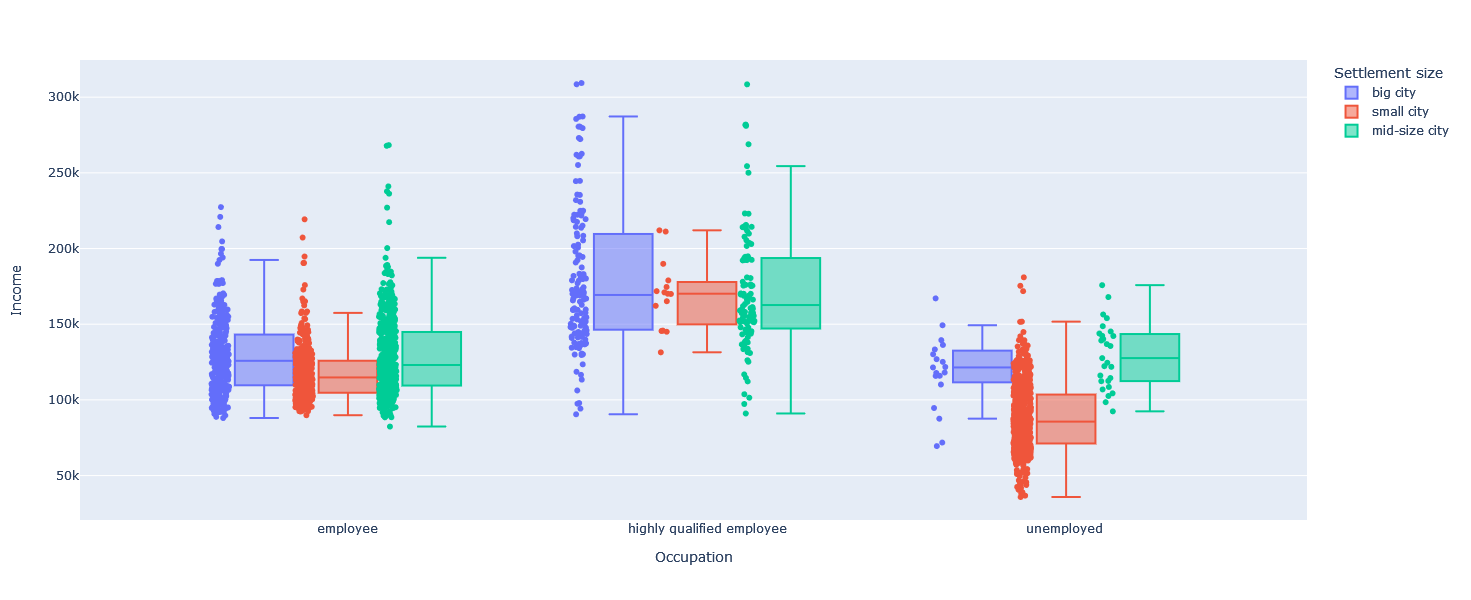

In [12]:
fig = px.box(data_view, x="Occupation", y ="Income",points="all",color = "Settlement size", width=1200, height=600)
fig.show()

Nota-se as médias de 'Income' por 'Occupation' bem próximas por tipo de 'settlement size', menos para o unemployed, onde a média para small city é bem menor que as demais. 

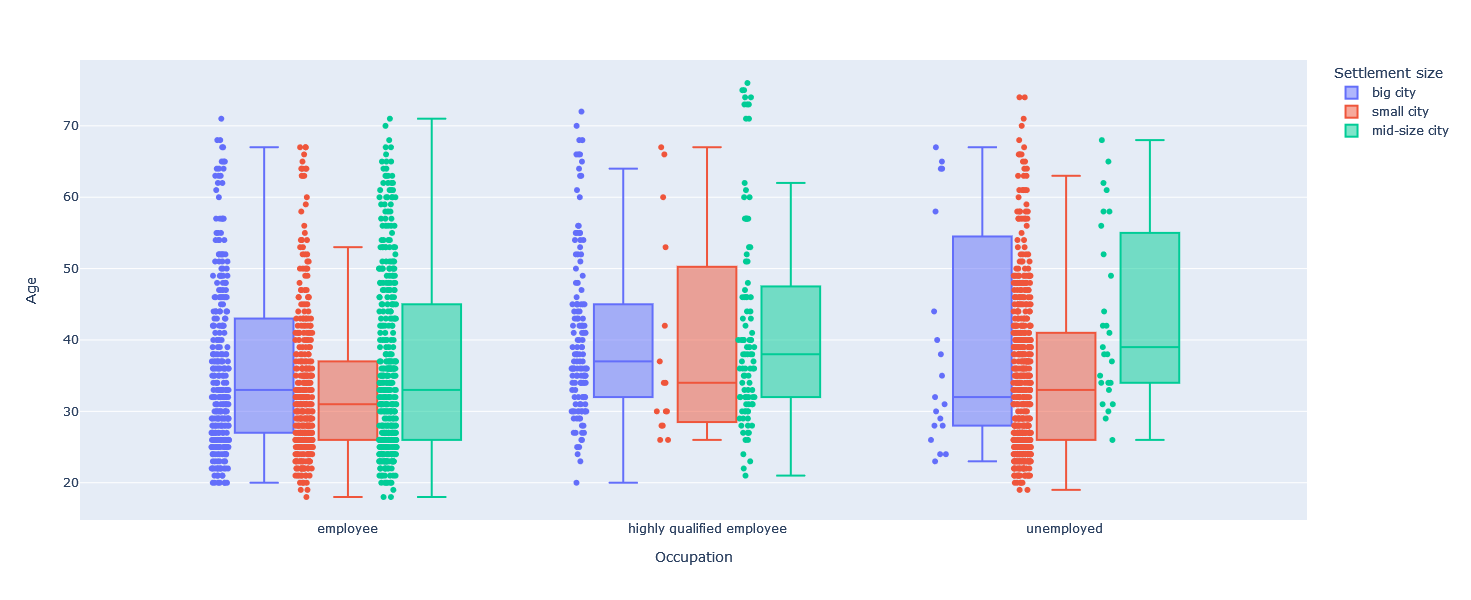

In [13]:
fig = px.box(data_view, x="Occupation", y ="Age",points="all",color = "Settlement size",width=1200, height=600)
fig.show()

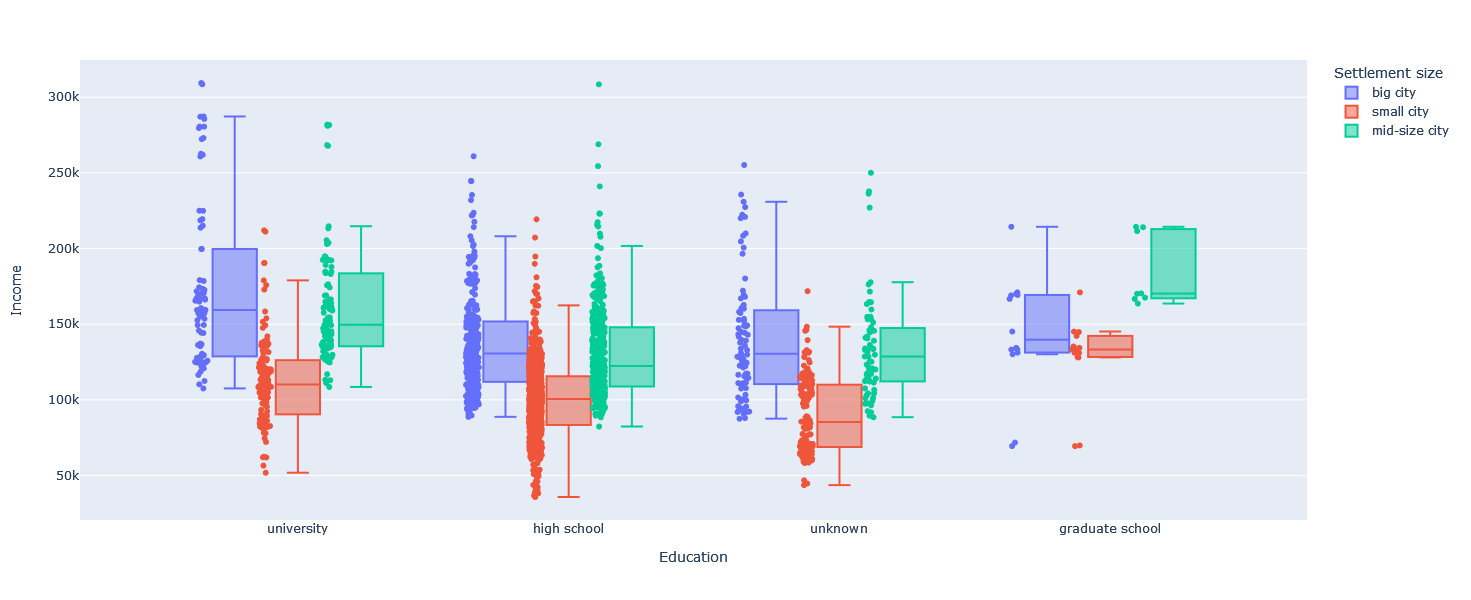

In [14]:
fig = px.box(data_view, x="Education", y ="Income",points="all",color = "Settlement size",width=1200, height=600)
fig.show()

Nota-se no gráfico de 'Income' por 'Education' uma diferença entre a média relativamente menor para o nivel de educação high school, university e unknown.

É possivel observar também que para o nível de educação graduate school existem poucos dados, mas é possível concluir que as pessoas que moram em mid-size city tem um salário médio maior se comparado com os outros níveis de 'Education'.

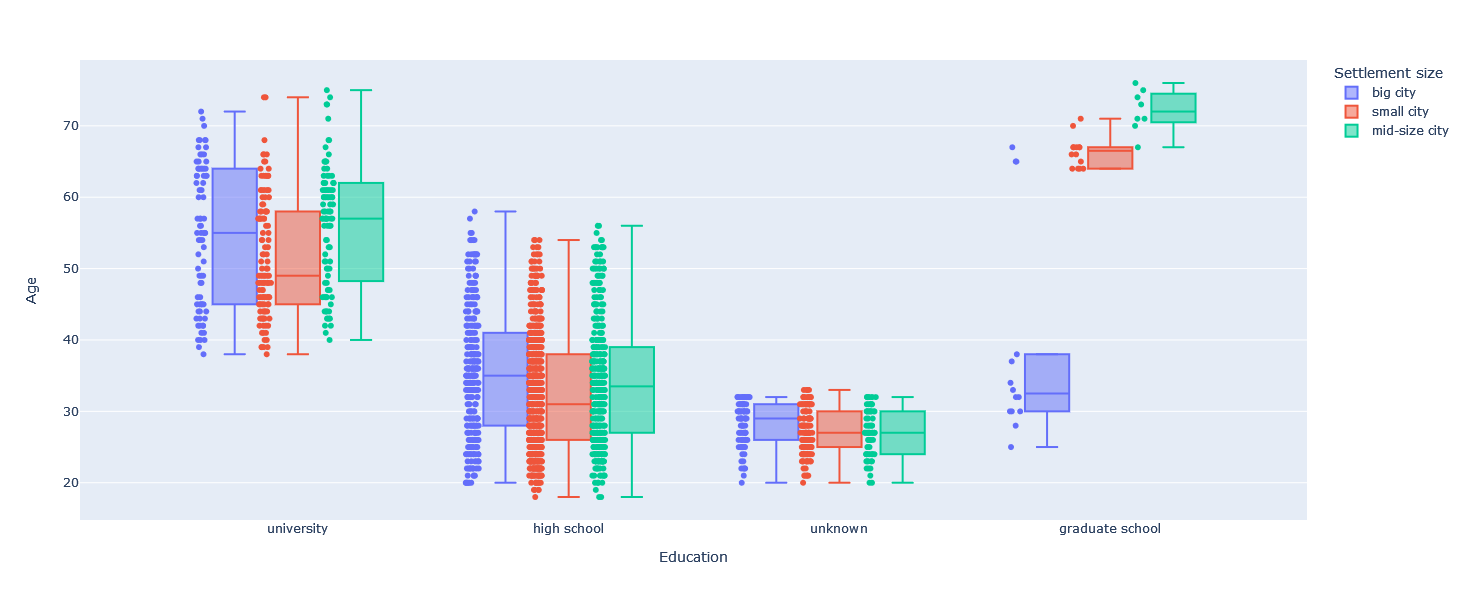

In [15]:
fig = px.box(data_view, x="Education", y ="Age",points="all",color = "Settlement size",width=1200, height=600)
fig.show()

Analisando o gráfico de 'Age' por 'Education' é possível notar que para o nível de ensino graduate school a maioria são pessoas idosas, com mais de 65 anos.

Nota-se também que para o nível unknown está na faixa dos 20 à 32 anos. Já para o nivel university está na faixa dos 38 à 72 anos. Para o nivel high school possui uma faixa bem grande de idade, indo de 20 à 60 anos.

No geral não existe uma diferença grande entre as distribuições de idade com base no 'Education', só existindo uma diferença notável no graduate school

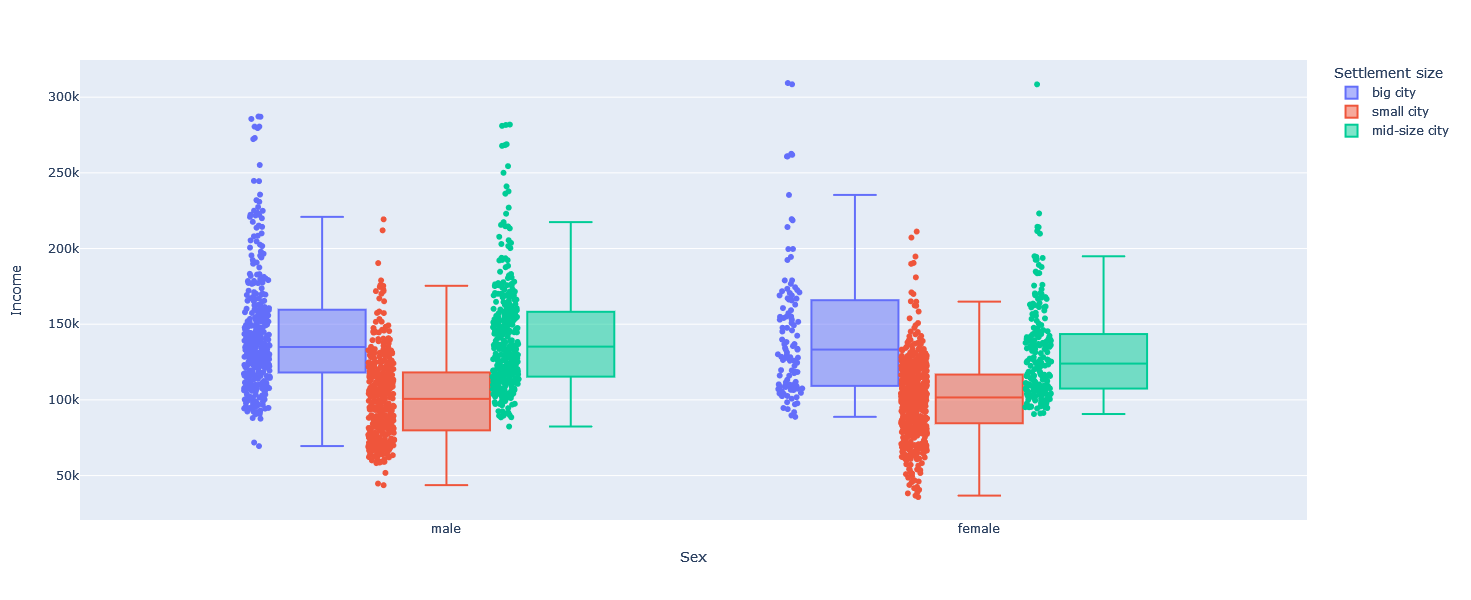

In [16]:
fig = px.box(data_view, x="Sex", y ="Income",points="all",color = "Settlement size",width=1200, height=600)
fig.show()

Em relação ao gráfico de 'Income' por 'Sex' as distribuições são similares, possuindo novamente uma média menor para small city.

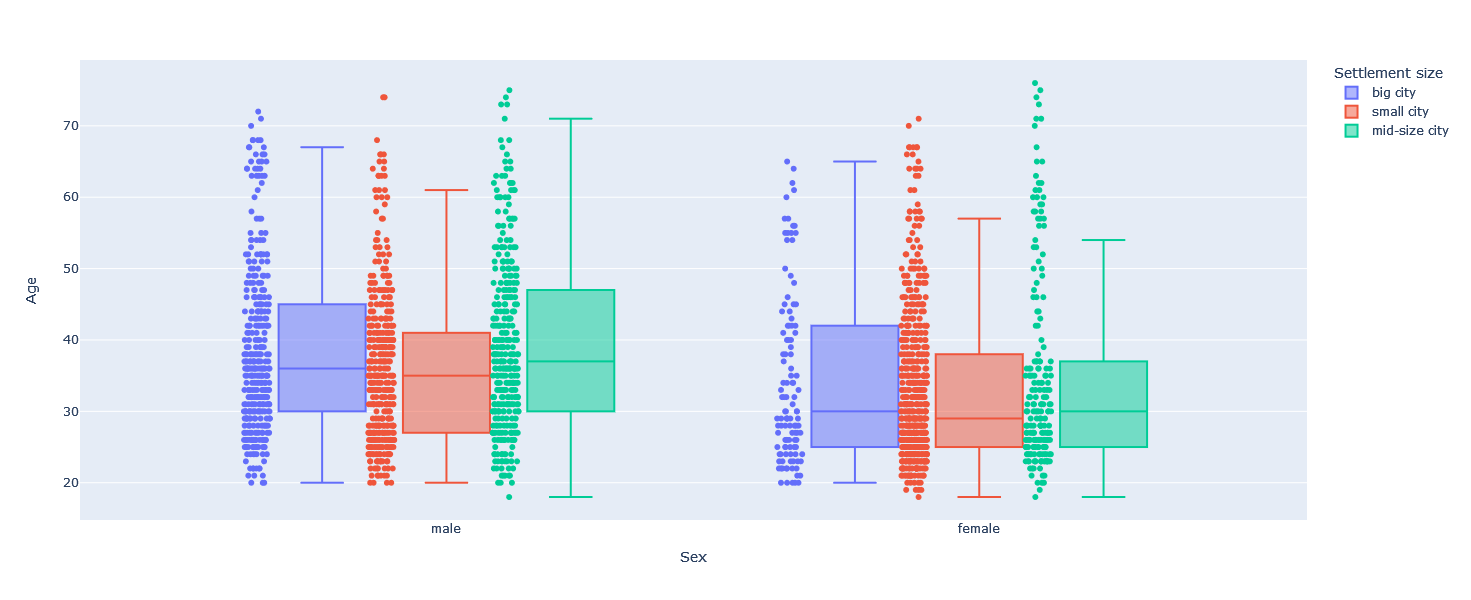

In [17]:
fig = px.box(data_view, x="Sex", y ="Age",points="all",color = "Settlement size",width=1200, height=600)
fig.show()

Em relação ao gráfico de 'Age' por 'Sex' nota-se que a média de idade dos homens é maior que a das mulheres para todos os 'settlement size'.

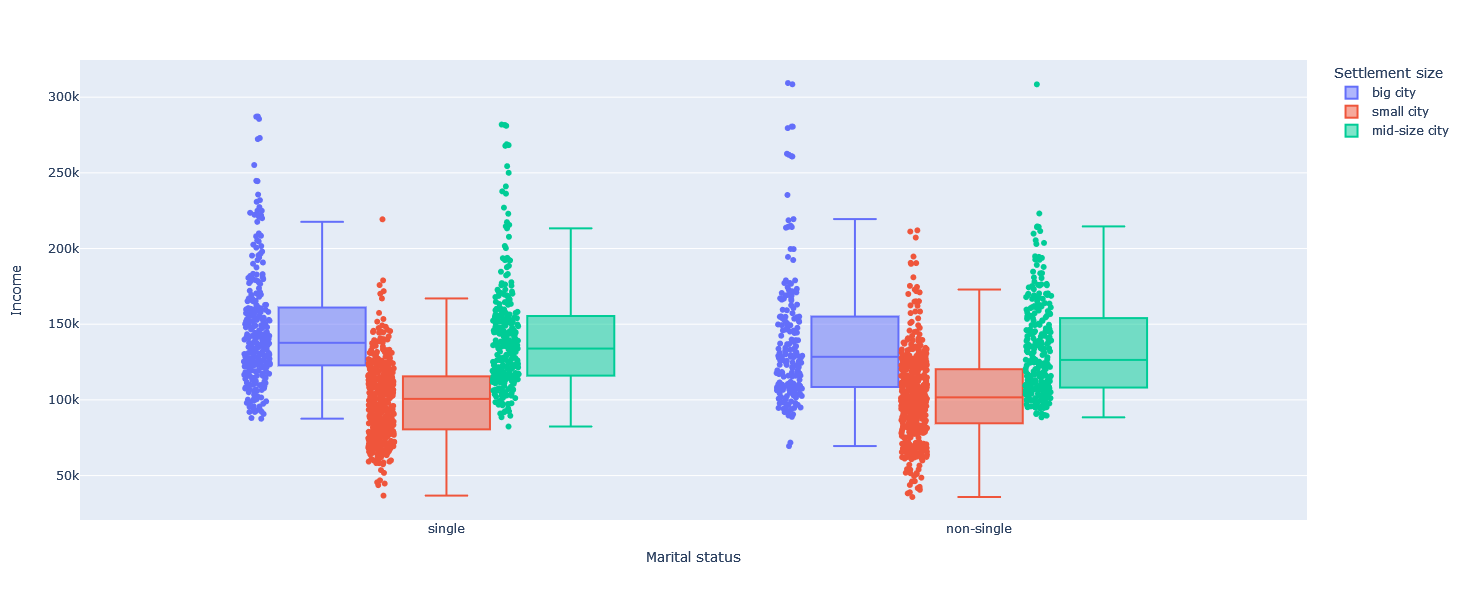

In [18]:
fig = px.box(data_view, x="Marital status", y ="Income",points="all",color = "Settlement size",width=1200, height=600)
fig.show()

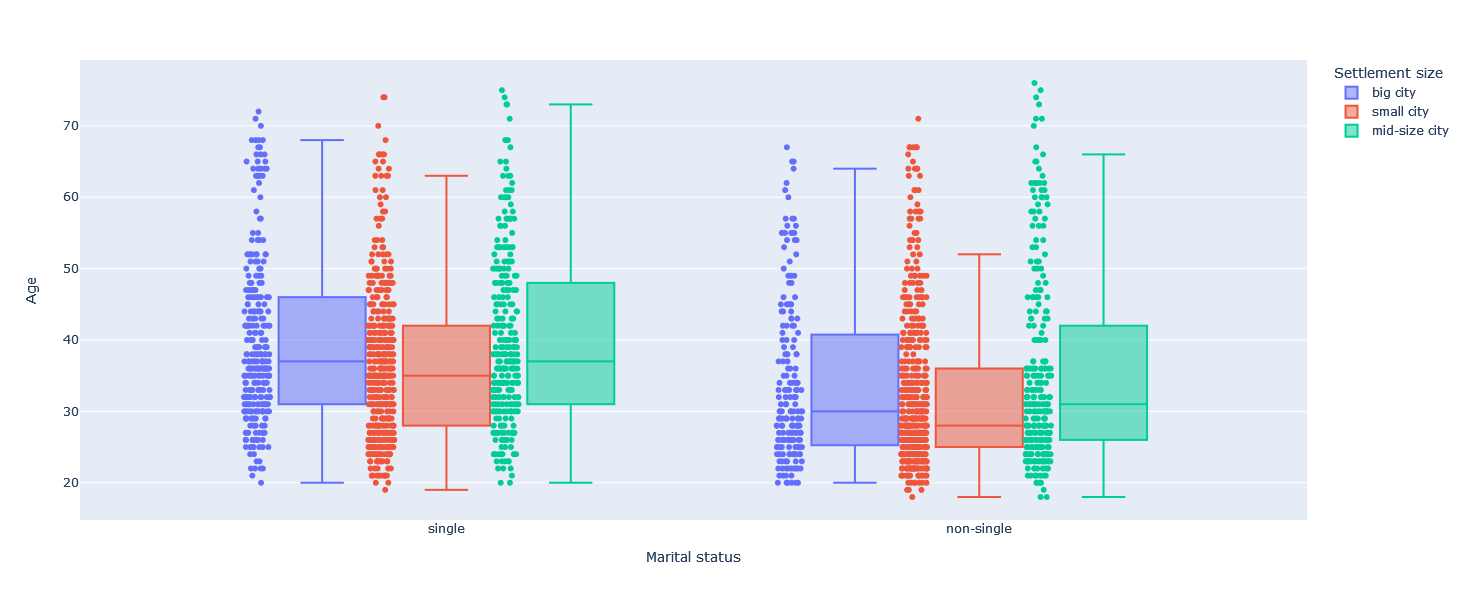

In [19]:
fig = px.box(data_view, x="Marital status", y ="Age",points="all",color = "Settlement size",width=1200, height=600)
fig.show()

Em relação ao gráfico de 'Marital status' por 'Income' não é possível concluir nada além do que já foi apresentado nos outros gráficos.

O mesmo acontece no gráfico de 'Marital status' por 'Age', onde o máximo que pode-se concluir é que a média das idades entre single e non-single são próximas, onde os single está entre 35 e 37 e os non-single entre 28 e 31.

<h3> Correlation data <h3>

<AxesSubplot:xlabel='x', ylabel='y'>

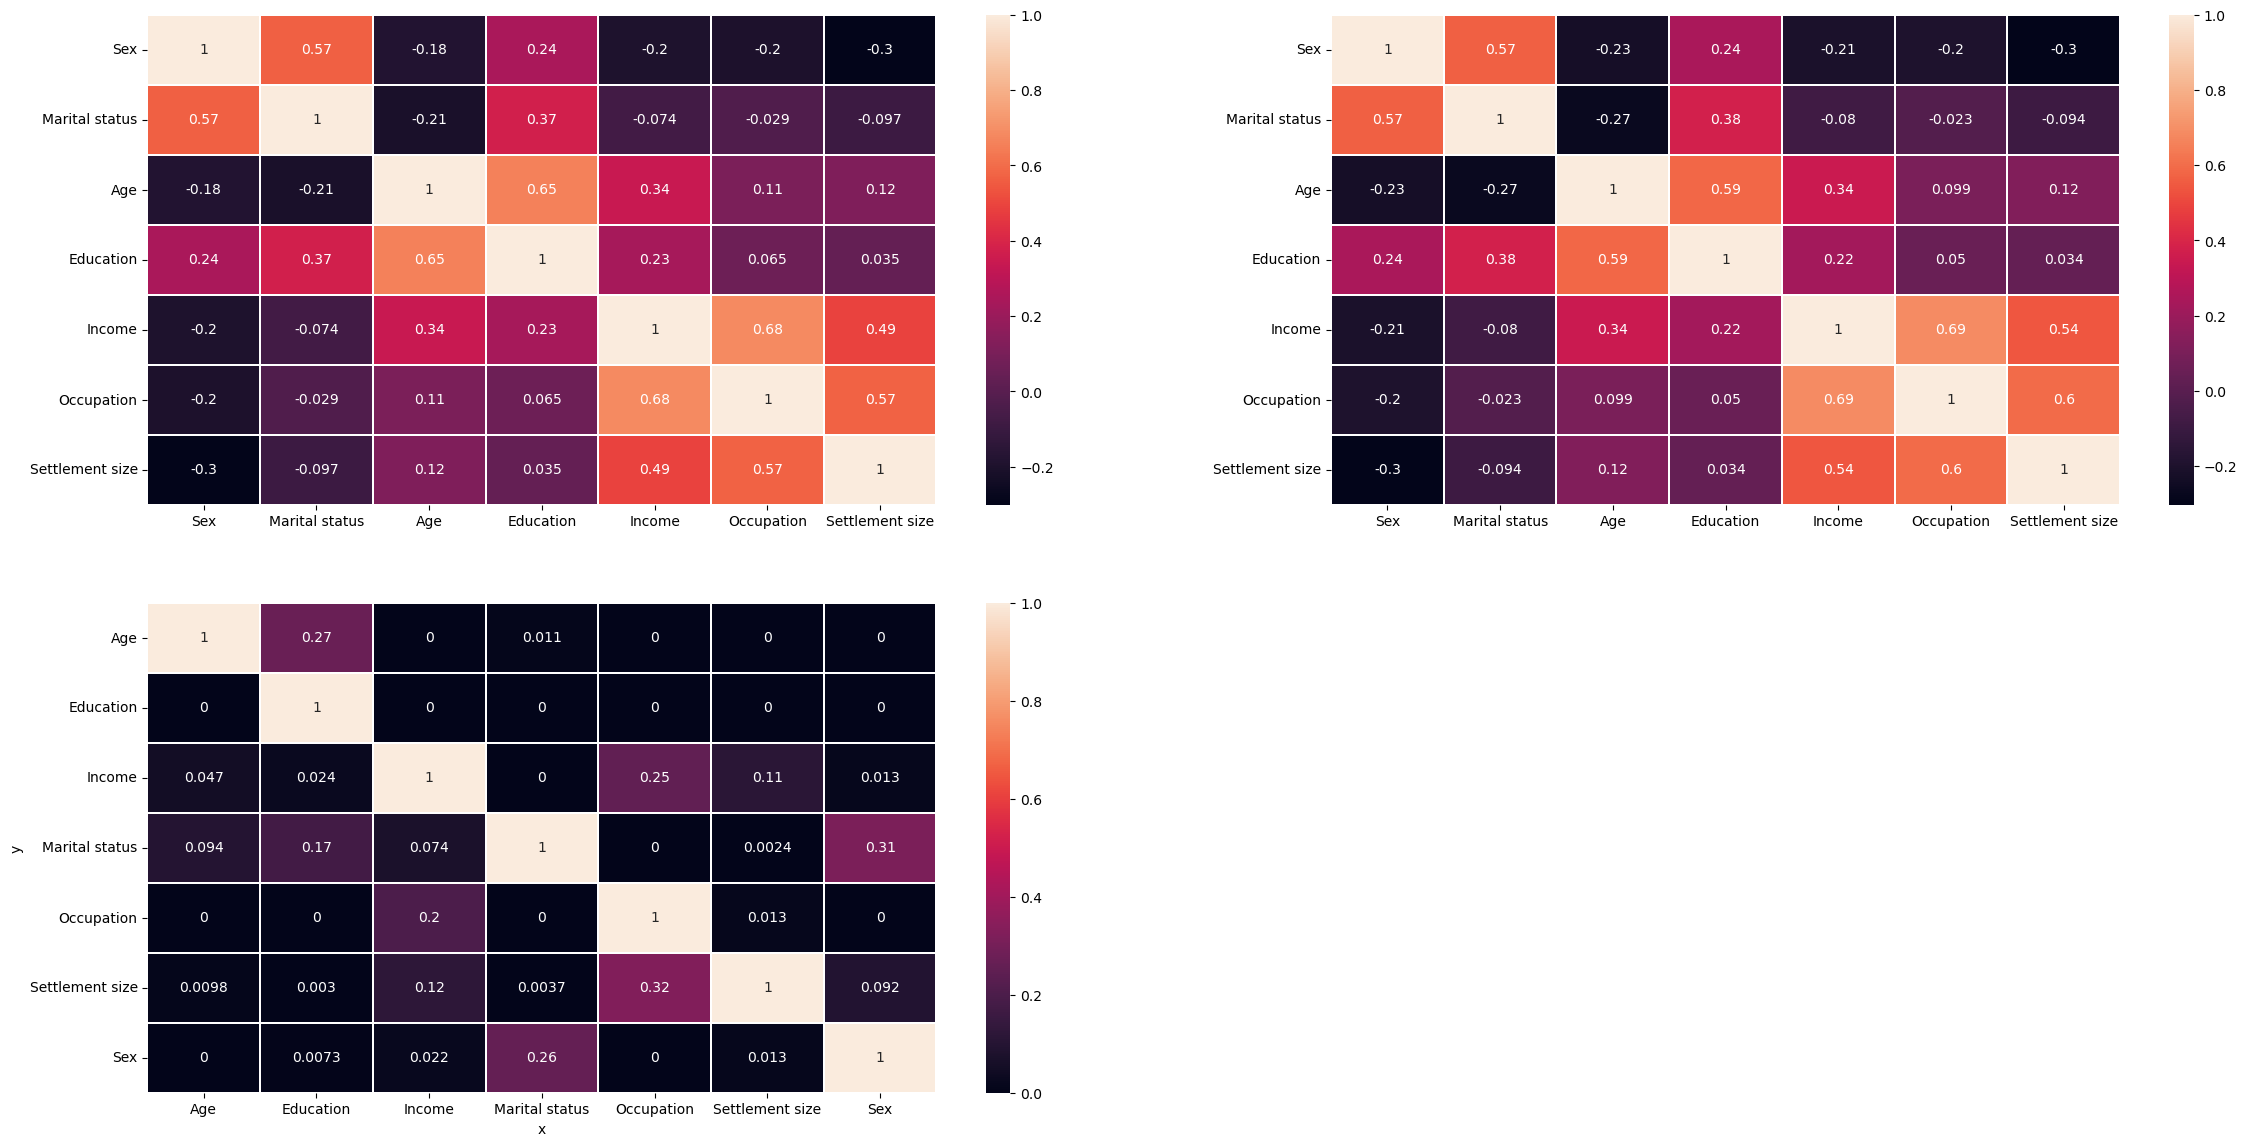

In [20]:
data.drop('ID', axis=1, inplace = True)
fig, axes = plt.subplots(2,2, figsize=(28,14))
fig.delaxes(axes[1,1])
pearson_matrix = data.corr(method='pearson')
spearman_matrix = data.corr(method='spearman')
pps_matrix = pps.matrix(data)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
sns.heatmap(pearson_matrix, annot=True,linewidths=.1, ax = axes[0,0])
sns.heatmap(spearman_matrix, annot=True,linewidths=.1, ax = axes[0,1])
sns.heatmap(pps_matrix, annot=True,linewidths=.1, ax = axes[1,0])

Nos gráficos apresentados nota-se certa correlação entre 'Occupation' e 'Income' e no caso de 'Education' e 'Age'.

Como em nenhum caso apresentou um alto valor de correlação nenhuma variável será removida.

<h1> Feature Engerring <h1>

<h3> Scaling data <h3>

Como o objetivo do projeto é a elaboração de grupos de clientes-alvos será utilizado um modelo de clusterização por meio do modelo K-means para a identificação destes grupos.

Por ser tratar de um modelo de clusterização baseado em distâncias euclidianas, os dados devem ser escalonados para que o modelo utilizado tenha maior precisão na geração dos grupos.

In [21]:
# Escalonando as variáveis
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaler = pd.DataFrame(scaler.fit_transform(data),columns=data.columns)
data_scaler

Sex  Marital status       Age  Education    Income  Occupation  \
0     0.0             0.0  0.844828   0.666667  0.324781         0.5   
1     1.0             1.0  0.068966   0.333333  0.420210         0.5   
2     0.0             0.0  0.534483   0.333333  0.195144         0.0   
3     0.0             0.0  0.465517   0.333333  0.496223         0.5   
4     0.0             0.0  0.603448   0.333333  0.413842         0.5   
...   ...             ...       ...        ...       ...         ...   
1995  1.0             0.0  0.500000   0.333333  0.320595         0.0   
1996  1.0             1.0  0.155172   0.333333  0.299460         0.5   
1997  0.0             0.0  0.224138   0.000000  0.184871         0.0   
1998  1.0             1.0  0.103448   0.333333  0.227162         0.0   
1999  0.0             0.0  0.120690   0.000000  0.119123         0.0   

      Settlement size  
0                 1.0  
1                 1.0  
2                 0.0  
3                 0.5  
4                 0.5  
...               ...  
1995              0.0  
1996              0.0  
1997              0.0  
1998              0.0  
1999              0.0  

[2000 rows x 7 columns]

**<h1> Model implementation <h1>**

<h3> K - Means <h3>

Para a implementação do modelo k-means inicialmente deve ser selecionado a quantidade de grupos a serem gerados. Para isto será utilizado quatro critérios diferentes para identificar a quantidade de clusters que devem ser gerados. Os critérios em questão são:
- The Elbow method, based in inertia.
- Silhouette criterion.
- Calinski and Harabasz criterion.
- Davies and Bouldin criterion.

Uma simples explicação dos ultimos três critérios pode ser encontrada no seguinte link: [How to measure clustering performances](https://medium.com/@haataa/how-to-measure-clustering-performances-when-there-are-no-ground-truth-db027e9a871c).

In [22]:
# Avaliando o número de clusters utilizados no K-means
wcss = []
sil = []
CeH = []
DeB = []
for i in range(2,21):
    kmeans_trib = KMeans(n_clusters = i, random_state = 0)
    kmeans_trib.fit(data_scaler)
    # Calculando as métricas
    aux1 = silhouette_score(data_scaler, kmeans_trib.labels_)
    aux2 = calinski_harabasz_score(data_scaler, kmeans_trib.labels_)
    aux3 = davies_bouldin_score(data_scaler, kmeans_trib.labels_)
    # Armazenando os valores das métricas calculadas
    wcss.append(kmeans_trib.inertia_)
    sil.append(aux1)
    CeH.append(aux2)
    DeB.append(aux3)

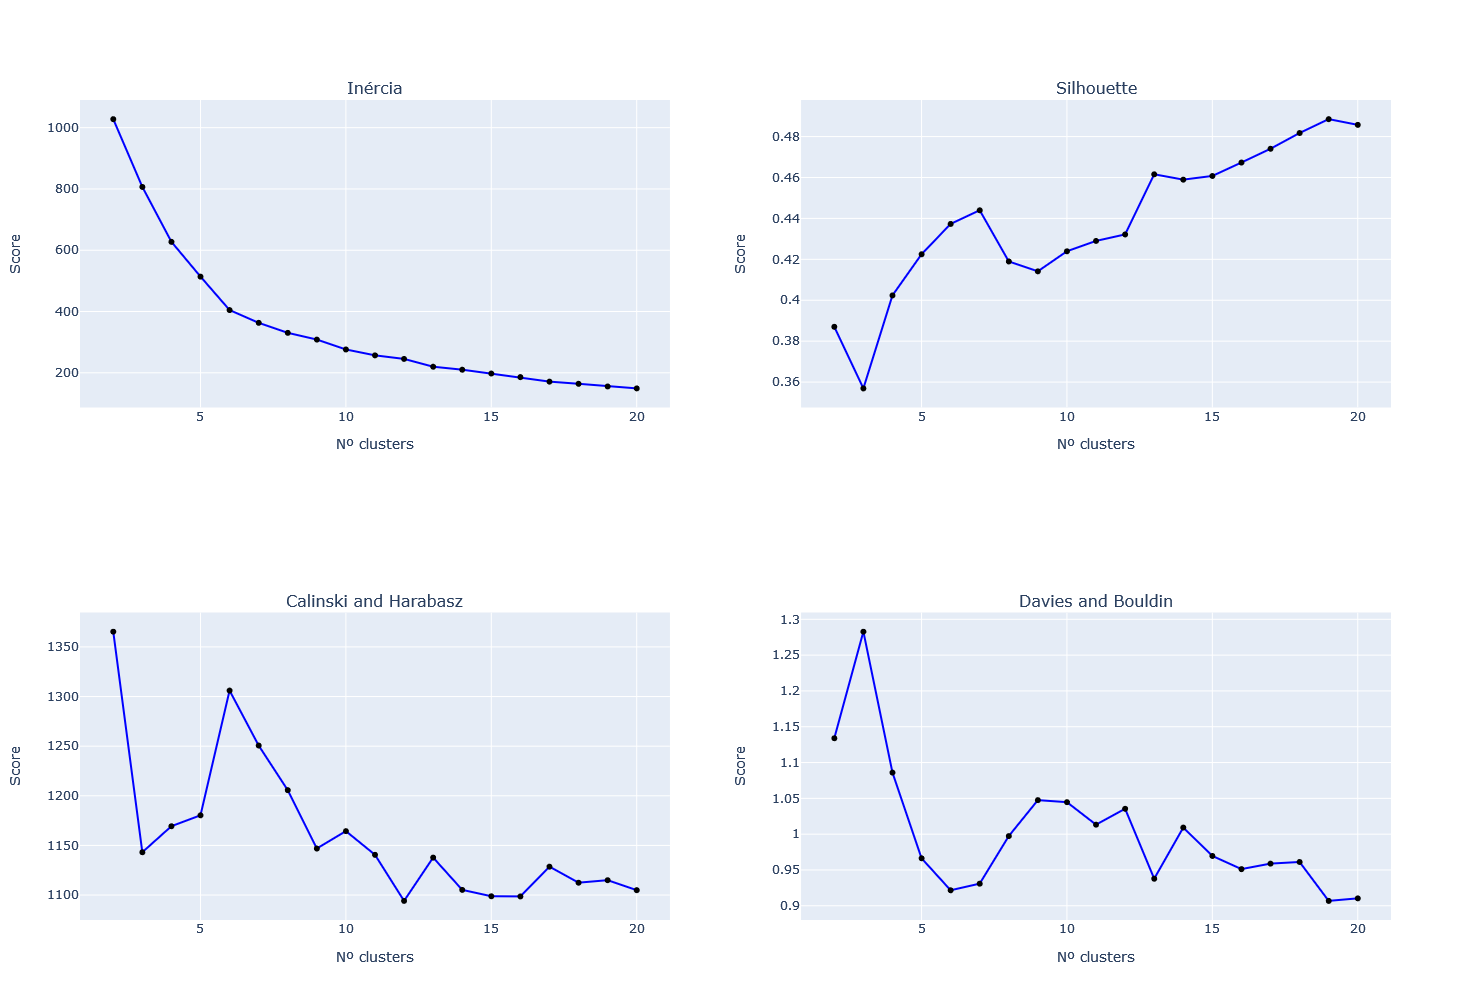

In [23]:
# Criando os gráficos das métricas

figu = make_subplots(rows = 2, cols = 2,subplot_titles=("Inércia", "Silhouette", "Calinski and Harabasz", "Davies and Bouldin"))
# Add traces
X = np.arange(2,21)
figu.add_trace(
    go.Scatter(x = X, y = wcss,mode='lines+markers',line={'color' : 'blue'}, marker = {'color' : 'black'}),
    row=1,col=1)
figu.add_trace(
    go.Scatter(x = X, y = sil,mode='lines+markers',line={'color' : 'blue'}, marker = {'color' : 'black'}),
    row=1,col=2)
figu.add_trace(
    go.Scatter(x = X, y = CeH,mode='lines+markers',line={'color' : 'blue'}, marker = {'color' : 'black'}),
    row=2,col=1)
figu.add_trace(
    go.Scatter(x = X, y = DeB,mode='lines+markers',line={'color' : 'blue'}, marker = {'color' : 'black'}),
    row=2,col=2)

# Update xaxis properties
figu.update_xaxes(title_text="Nº clusters", row=1, col=1)
figu.update_xaxes(title_text="Nº clusters", row=1, col=2)
figu.update_xaxes(title_text="Nº clusters", row=2, col=1)
figu.update_xaxes(title_text="Nº clusters", row=2, col=2)

# Update yaxis properties
figu.update_yaxes(title_text="Score", row=1, col=1)
figu.update_yaxes(title_text="Score", row=1, col=2)
figu.update_yaxes(title_text="Score", row=2, col=1)
figu.update_yaxes(title_text="Score", row=2, col=2)
figu.update_layout(showlegend=False,height=1000, width=1000)
figu.show()

Observando os gráficos tem-se que:
- Para o critério de inércia o ponto de inflexão ocorre com o número de clusters igual à 6.
- Para o critério de Silhouette  o ponto que apresenta o maior valor de score é o que possui 19 clusters.
- Para o critério de Calinski and Harabasz o primeiro ponto de inflexão positivo ocorre com número de clusters igual à 6.
- Pelo critério de Davis and Bouldin o ponto que apresenta menor valor de score é o que possui 19 clusters.

Como provavelmente a loja não se trada de uma grande corporação ou possui várias filiais da onde estes dados foram retirados eu considero que a menor quantidade de grupos gerada seja o melhor para fazer uma análise inicial de publico alvo para a equipe de marketing. Portanto será utilizado 6 clusters para o resto das análises.

<h3> Cluster vizualization - PCA <h3>

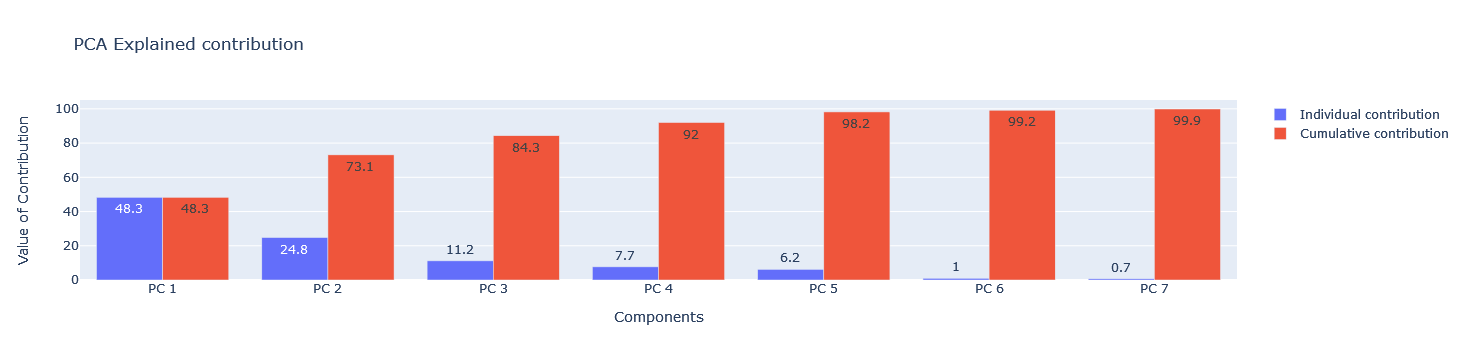

In [73]:
pca = PCA()
pca_components = pca.fit(data_scaler)
var = np.round(pca.explained_variance_ratio_*100, decimals = 1)
var_cumulative = np.zeros(len(var))
var_cumulative[0] = var[0]
for i in range(1,len(var)):
    var_cumulative[i] = var[i]+var_cumulative[i-1]

labels = [
    f"PC {i+1}"
    for i in range(0,len(var))
]

fig = go.Figure()
fig.add_trace(go.Bar(
    x = labels,
    y= var,
    text = var,
    name='Individual contribution'))

fig.add_trace(go.Bar(
    x = labels,
    y = var_cumulative,
    text = var_cumulative,
    name ='Cumulative contribution'))

fig.update_layout(barmode='group',
                  title="PCA Explained contribution",
                  xaxis_title="Components",
                  yaxis_title="Value of Contribution")

fig.show()

Observando o gráfico nota-se que a explicabilidade do dados com três componentes é de 84,3% sendo um valor que eu considero razoável para a vizualização dos dados.

In [77]:
kmeans_trib = KMeans(n_clusters = 6, random_state = 0)
kmeans_trib.fit(data_scaler)
data['class'] = kmeans_trib.labels_
for i in range(0,max(kmeans_trib.labels_)+1):
    var = 'class '+ str(i+1)
    data['class'] = data['class'].replace(i,var)
data_view['class'] = data['class']

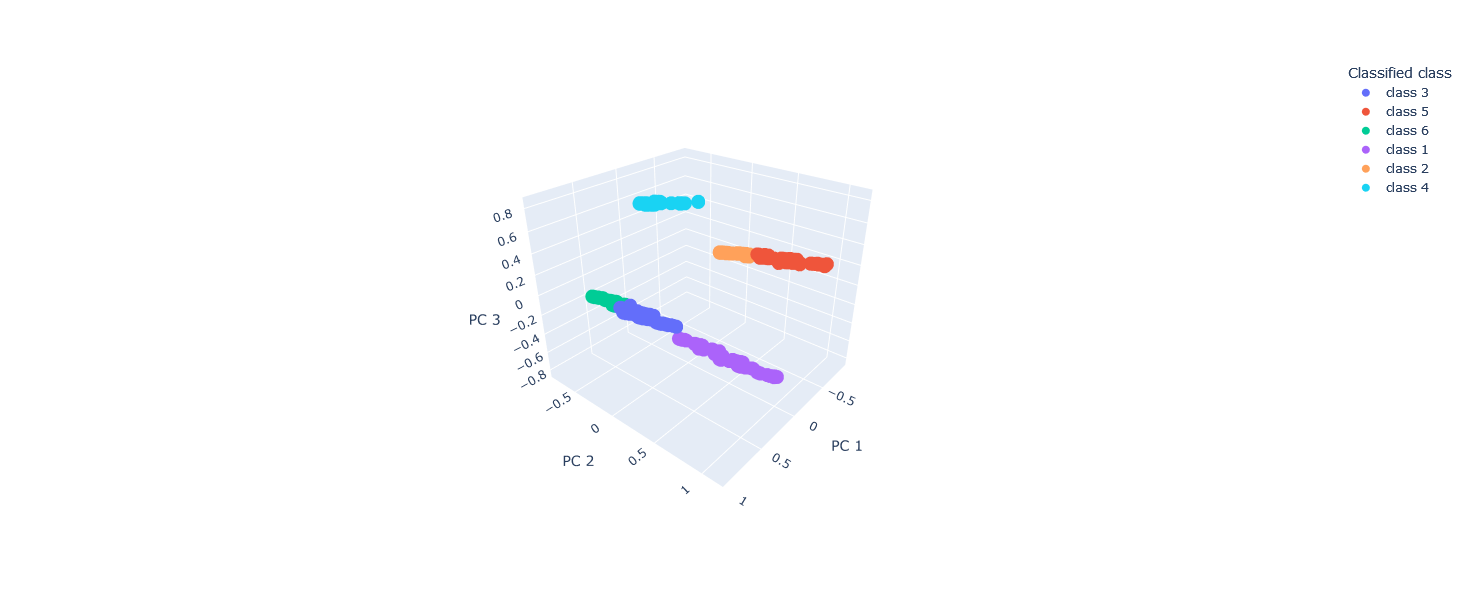

In [76]:
pca = PCA(3)
pca_components=pca.fit(data_scaler)
scores_pca = pca.transform(data_scaler)
pca_data = pd.DataFrame(scores_pca, columns=['PC 1','PC 2','PC 3']) 
pca_data['class'] = data['class']

fig = px.scatter_3d(pca_data,x = 'PC 1', y = 'PC 2', z = 'PC 3' ,color='class',width=1200,height = 600, labels={"class":"Classified class"})
fig.show()

Analisando o gráfico gerado tem-se que as classes 1 e 4 estão bem isoladas podendo representar grupos distintos de clintes-alvo.

Para as classes 6 e 3, pela vizualização elas estão muito próximas, necessitando verificar se estes grupos realmente possuem características diferentes entre eles. O mesmo problema acontece com as classes 2 e 5, necessitando também serem analisados. 

In [ ]:
cond = (data_view['class']== 'class 3') | (data_view['class']== 'class 6')
dat_view = data_view.loc[cond].copy()
fig = px.scatter_matrix(dat_view,dimensions=["Marital status","Age","Education","Income","Occupation","Sex"], color ="class")
#fig.update_traces(diagonal_visible=False)
fig.update_layout(
    dragmode='select',
    width=1400,
    height=1400,
    hovermode='closest',
)
fig.show()

NameError: name 'data_view' is not defined

Analisando os gráficos vemos que as class 3 e 6 englobam uma parcela dos dados dos homens solteiros. Examinando os gráficos 'Income' é visível diferença os dois grupos e obsevando os gráficos de 'Occupation' nota-se uma separação entre eles.

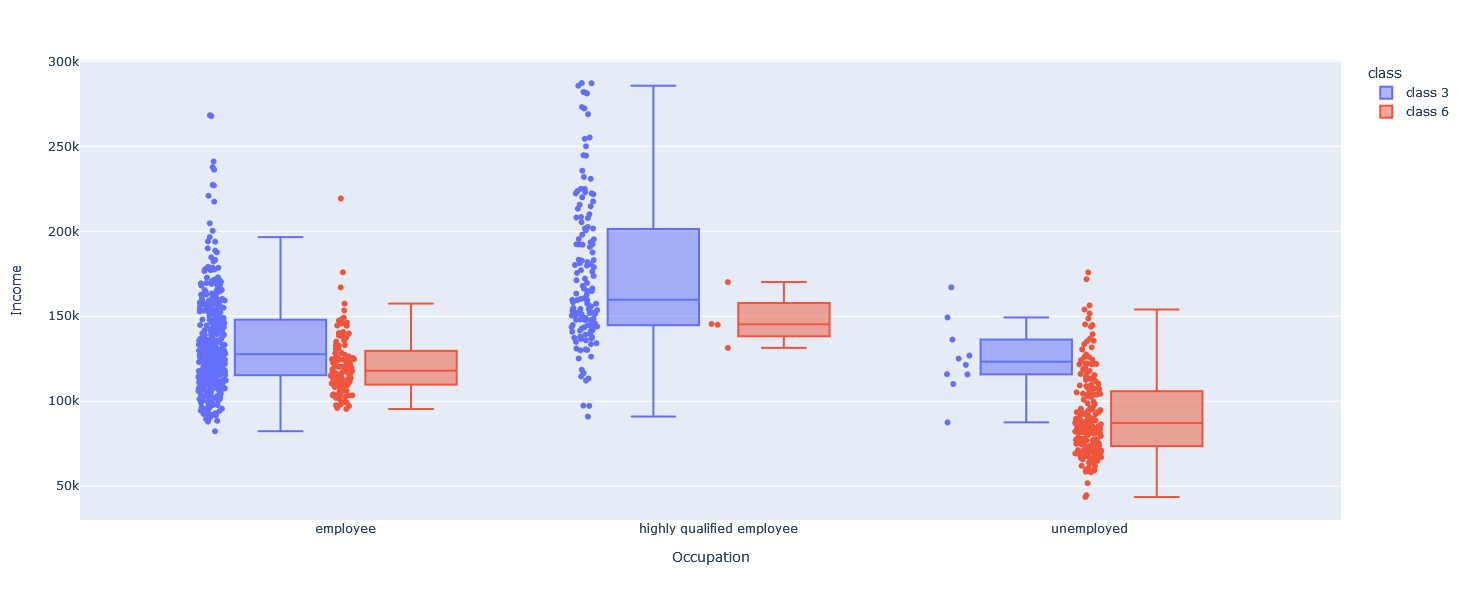

In [94]:
fig = px.box(dat_view, x="Occupation", y ="Income",points="all",color='class', width=1200, height=600)
fig.show()

Analisando o gráfico é perceptível que o grupo 6 aborda um grupo onde possuem pessoas desempregadas e empregos com menor valor de 'Income', já o grupo 3 engloba pessoas com empregos mais qualificados e empregos com uma renda um pouco maior.

Apesar dos dois grupos abordarem homens solteiros, existe uma diferença entre eles que é relevante no momento de criar estratégias de venda entre esses grupos.

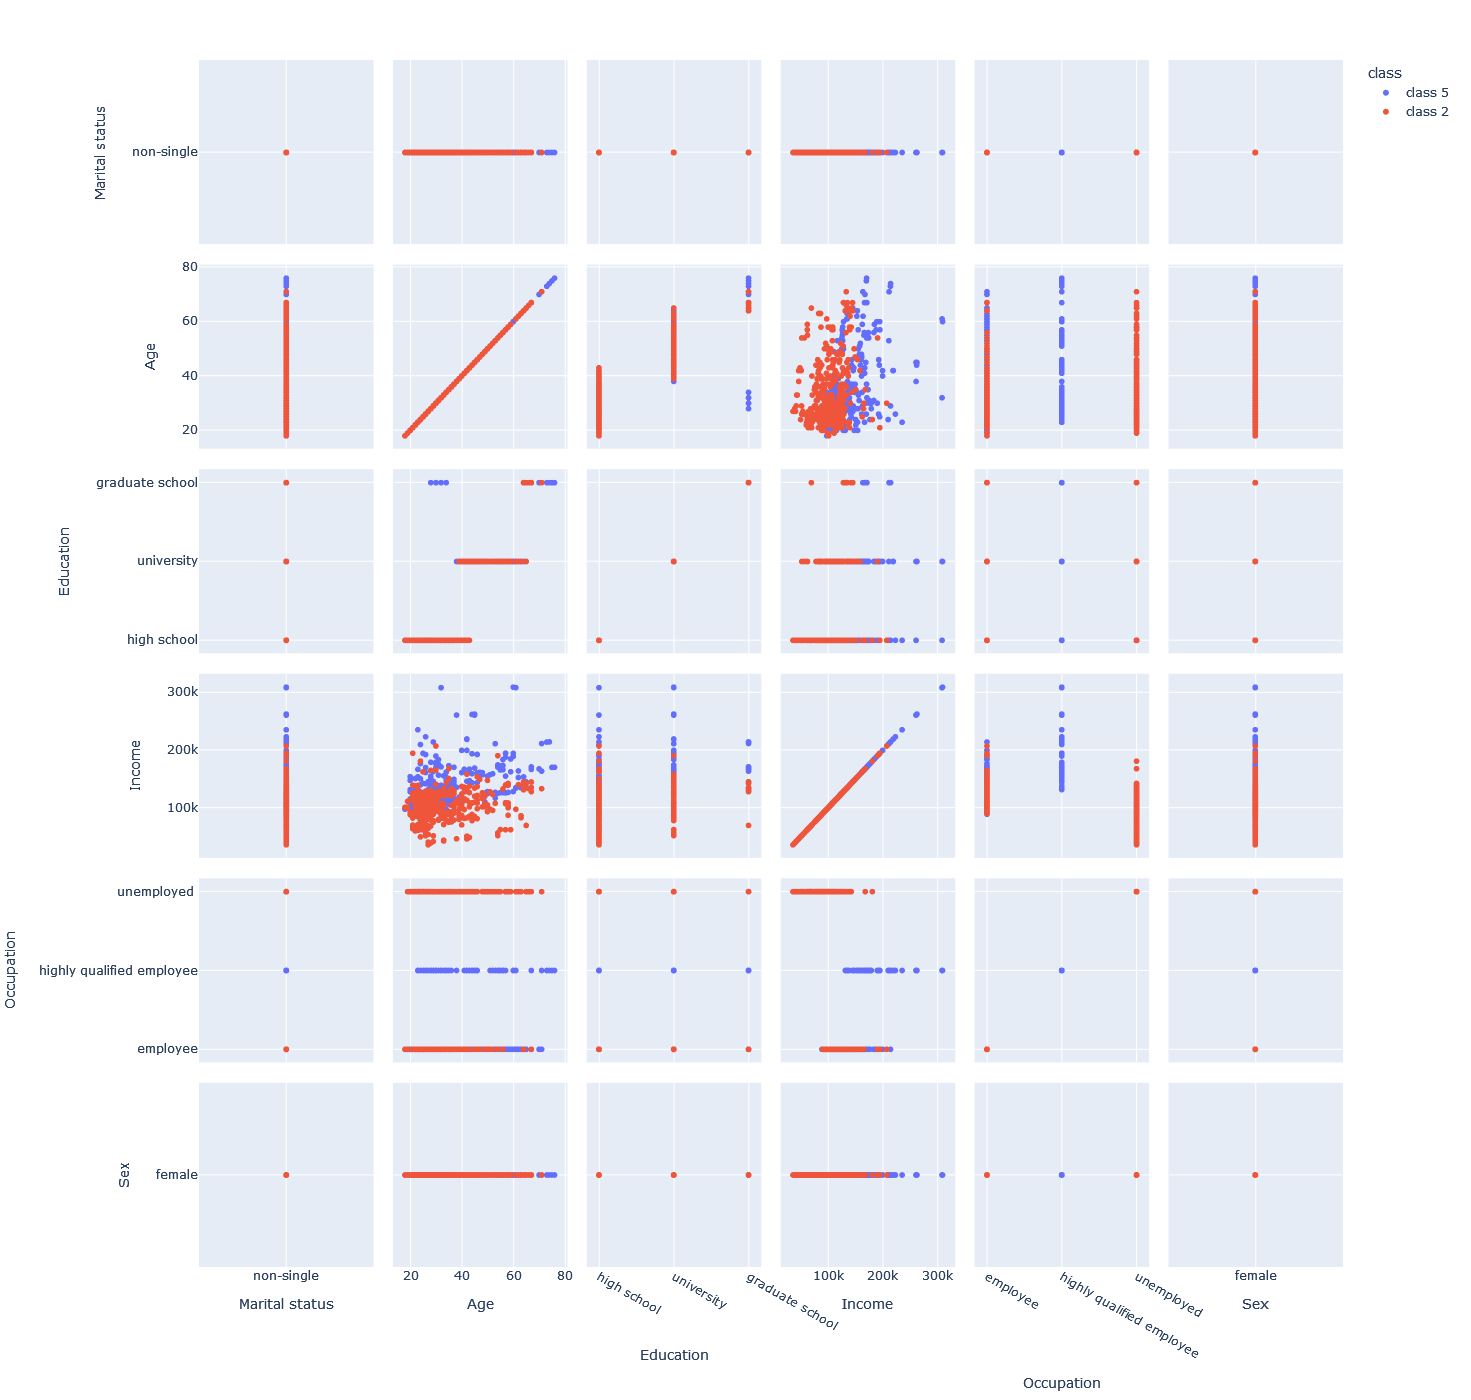

In [95]:
cond = (data_view['class']== 'class 2') | (data_view['class']== 'class 5')
dat_view2 = data_view.loc[cond].copy()
fig = px.scatter_matrix(dat_view2, dimensions=["Marital status","Age","Education","Income","Occupation","Sex"], color ="class")
#fig.update_traces(diagonal_visible=False)
fig.update_layout(
    dragmode='select',
    width=1400,
    height=1400,
    hovermode='closest',
)
fig.show()

Analisando os gráficos vemos que as class 2 e 5 englobam uma parcela dos dados dos mulheres non-single. Examinando os gráficos 'Occupation' é visível diferença os dois grupos, e obsevando os gráficos de 'Income' é possível perceber uma pequena distinção entre os grupos.

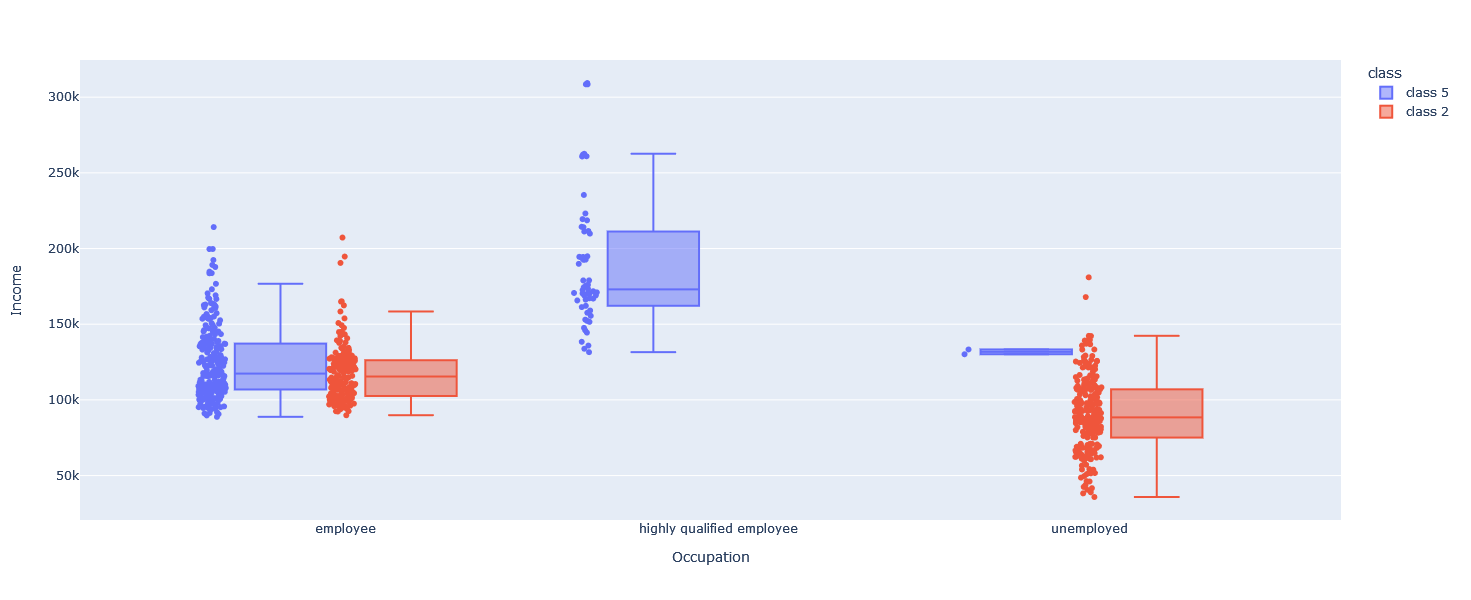

In [98]:
fig = px.box(dat_view2, x="Occupation", y ="Income",points="all",color='class', width=1200, height=600)
fig.show()

Aparentemente ocorreu o mesmo tipo de separação das class 3 ans 6, só que mais expressiva em relação ao 'Occupation' visto que para a classe 2 não existe highly qualified employee e para a class 5 quase não tem pontos de unemployed.

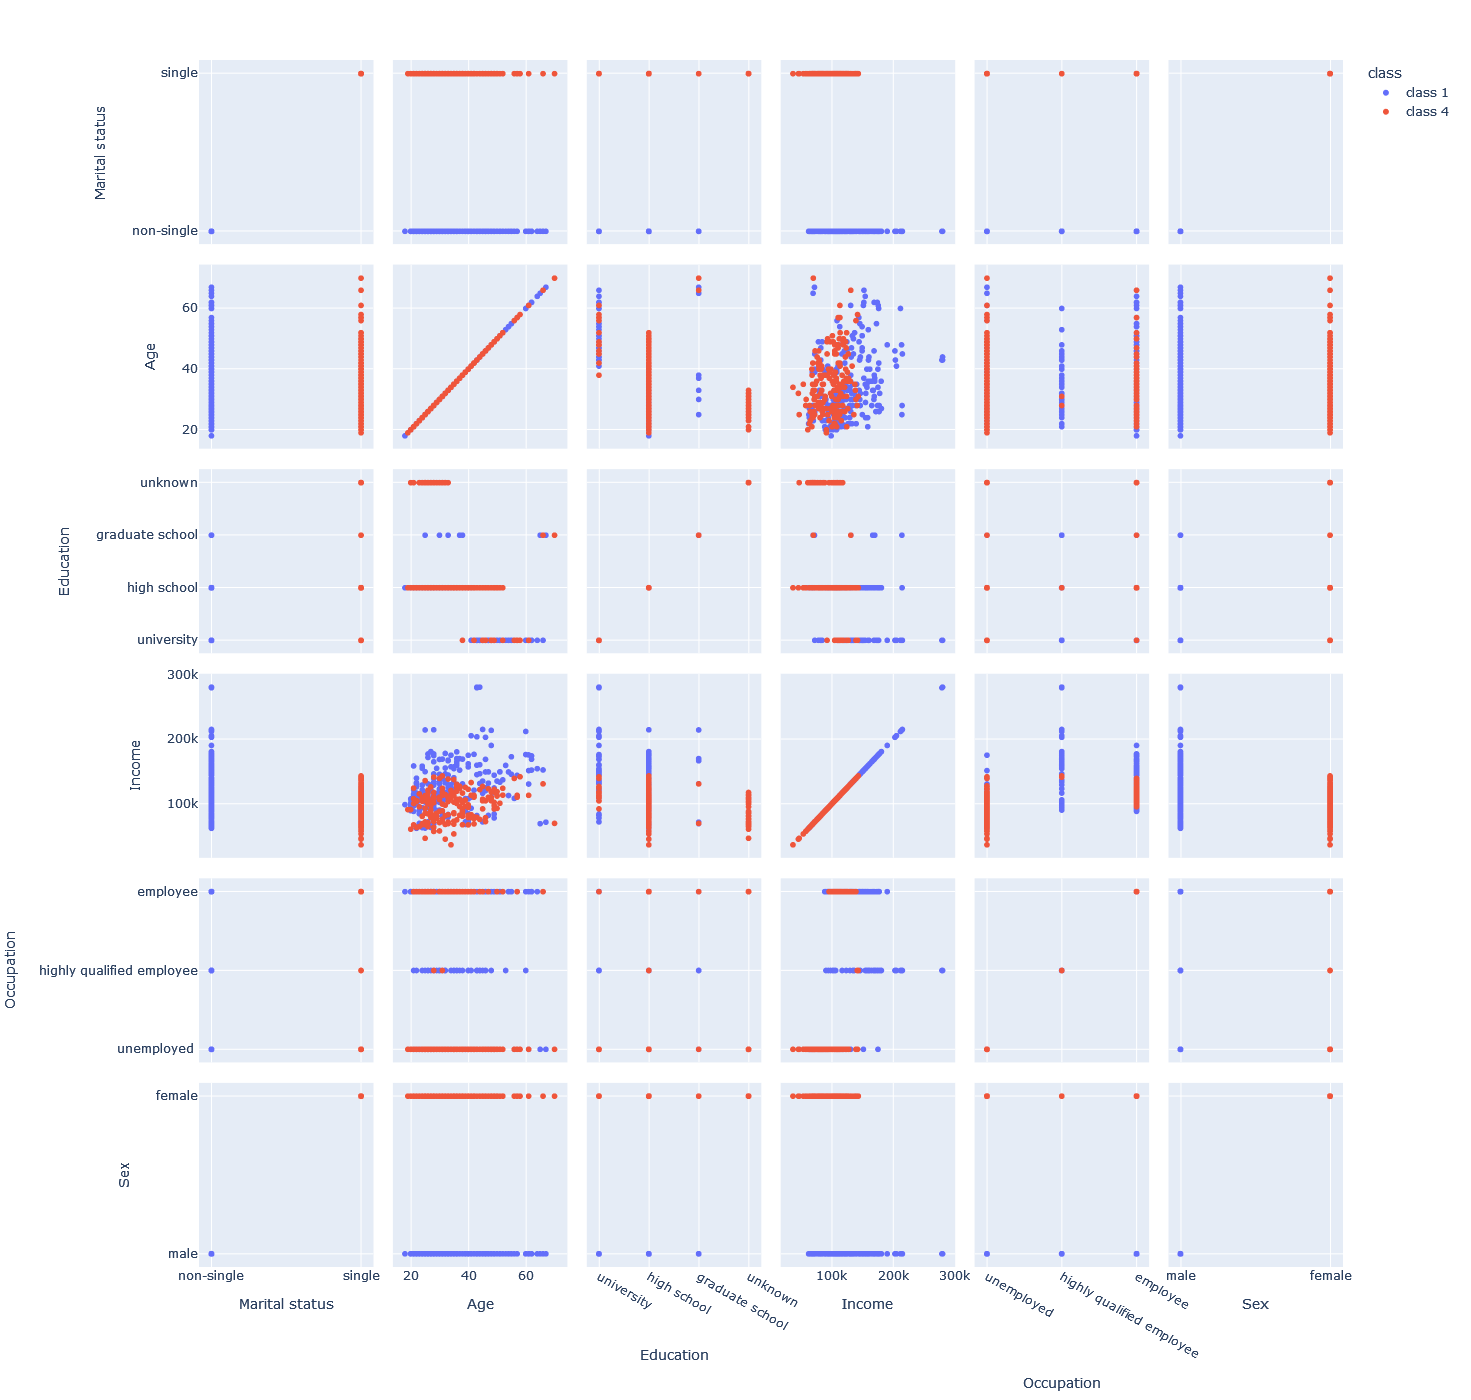

In [99]:
cond = (data_view['class']== 'class 1') | (data_view['class']== 'class 4')
dat_view3 = data_view.loc[cond].copy()
fig = px.scatter_matrix(dat_view3, dimensions=["Marital status","Age","Education","Income","Occupation","Sex"], color ="class")
#fig.update_traces(diagonal_visible=False)
fig.update_layout(
    dragmode='select',
    width=1400,
    height=1400,
    hovermode='closest',
)
fig.show()

Examinando os ultimos dois grupos nota-se que a separação da class 1 foi baseada em homens non-single enquanto a class 4 foi baseada em mulheres single.

**<h1>Conclusion<h1>**

Com isso, foram descobertos 6 grupos distintos que podem ser trabalhados em conjunto com a equipe de marketing para que possa ser elaborado novas estratégias para aumentar a quantidade de vendas.

Caso o dataset também fornece-se dados de gasto ou produtos comprados na loja poderia ser feito uma análise dos grupos formados visando aumentar o número de vendas da loja em questão ou até mesmo criar sistema de vendas casadas de produtos e sistema de fidelidades voltado para um grupo específico.